# 第3章 TensorFlow构建模型的方法

## 3.1 利用低阶API构建模型
	用TensorFlow低阶API构建模型主要包括张量操作、计算图及自动微分等操作，这种方法灵活性高，如果构建模型继承tf.Module，还可以轻松实现保存模型及跨平台部署。为提高模型运行效率，我们还可以使用@tf.function装饰相关函数，使之转换为自动图。为了更好地掌握本节的相关内容，这里以分类项目为例。
### 3.1.1 项目背景
	这里以CIFAR-10为数据集，数据导入和预处理使用自定义函数，为更有效地处理数据，这里使用tf.data工具。有关tf.data的详细使用将在第4章将介绍，这里不再详述。构建模型只使用TensorFlow的低阶API，如tf.Variable、tf.nn.relu、自动微分等。然后自定义训练过程，最后保存和恢复模型。
	CIFAR-10为小型数据集，一共包含10个类别的 RGB 彩色图像：飞机（airplane）、汽车（automobile）、鸟类（bird）、猫（cat）、鹿（deer）、狗（dog）、蛙类（frog）、马（horse）、船（ship）和卡车（truck）。图像的尺寸为 32×32（像素），3个通道 ，数据集中一共有 50000 张训练圄片和 10000 张测试图像。CIFAR-10数据集有3个版本，这里使用Python版本。


### 3.1.2 导入数据
1）导入需要的模块。

In [1]:
import os
import math
import numpy as np
import pickle as p
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


2）定义导入单批次的函数。因数据源分成几个批次，这里定义一个导入各批次的函数。

In [2]:
def load_CIFAR_batch(filename):
    """ 导入单批次的cifar数据 """  
    with open(filename, 'rb')as f:
        data_dict = p.load(f, encoding='bytes')
        images= data_dict[b'data']
        labels = data_dict[b'labels']
                
        # 把原始数据结构调整为: BCWH
        images = images.reshape(10000, 3, 32, 32)
        # tensorflow处理图像数据的结构：BWHC
        # 把通道数据C移动到最后一个维度
        images = images.transpose (0,2,3,1)
     
        labels = np.array(labels)
        
        return images, labels


3）导入整个数据集。

In [3]:
def load_CIFAR_data(data_dir):
    """导入CIFAR数据集"""
 
    images_train=[]
    labels_train=[]
    for i in range(5):
        f=os.path.join(data_dir,'data_batch_%d' % (i+1))
        print('loading ',f)
        # 调用 load_CIFAR_batch( )获得批量的图像及其对应的标签
        image_batch,label_batch=load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain=np.concatenate(images_train)
        Ytrain=np.concatenate(labels_train)
        del image_batch ,label_batch
    
    Xtest,Ytest=load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    # 返回训练集的图像和标签，测试集的图像和标签
    return (Xtrain,Ytrain),(Xtest,Ytest)

4）指定数据文件所在路径。

In [5]:
data_dir = '../../data/cifar-10-batches-py/'
(x_train,y_train),(x_test,y_test) = load_CIFAR_data(data_dir)

loading  ../../data/cifar-10-batches-py/data_batch_1
loading  ../../data/cifar-10-batches-py/data_batch_2
loading  ../../data/cifar-10-batches-py/data_batch_3
loading  ../../data/cifar-10-batches-py/data_batch_4
loading  ../../data/cifar-10-batches-py/data_batch_5
finished loadding CIFAR-10 data


5）说明类别及对应索引，并随机可视化其中5张图像。

In [6]:
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer",
              5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}


def plot_images_labels(images, labels, num):
    total = len(images)
    fig = plt.gcf()
    fig.set_size_inches(15, math.ceil(num / 10) * 7)
    for i in range(0, num):
        choose_n = np.random.randint(0, total)
        
        ax = plt.subplot(math.ceil(num / 5), 5, 1 + i)
        ax.imshow(images[choose_n], cmap='binary')
        title = label_dict[labels[choose_n]]
        ax.set_title(title, fontsize=10)        
    plt.show()

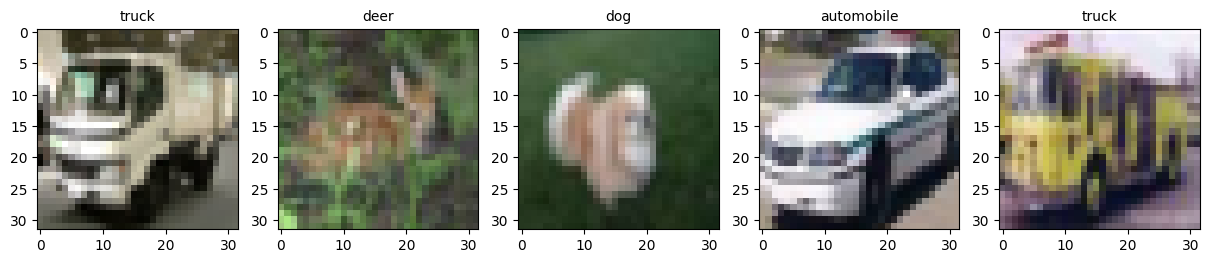

In [7]:
plot_images_labels(x_train, y_train, 5)

<center>图3-1 随机抽取CIFAR-10数据集中5张图</center>

### 3.1.3 预处理数据
1）对数据进行简单处理。对数据进行规范化，并设计相关超参数等。

In [8]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

train_num = len(x_train)
num_classes = 10

learning_rate = 0.0002
batch_size = 64
training_steps = 40000
display_step = 1000

2）使用TensorFlow的数据预处理工具tf.data,使预处理过程打包成为一个管道。

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(5000).repeat(training_steps).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

Metal device set to: Apple M2 Pro


2023-11-26 23:58:42.500458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-26 23:58:42.500700: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


dataset 中 shuffle()、repeat()、batch()、prefetch()等函数的主要功能如下。  
1）repeat(count=None) 表示重复此数据集 count 次，实际上，我们看到 repeat 往往是接在 shuffle 后面的。为何要这么做，而不是反过来，先 repeat 再 shuffle 呢？ 如果shuffle 在 repeat 之后，epoch 与 epoch 之间的边界就会模糊，出现未遍历完数据，已经计算过的数据又出现的情况。  
2）shuffle(buffer_size, seed=None, reshuffle_each_iteration=None) 表示将数据打乱，数值越大，混乱程度越大。为了完全打乱，buffer_size 应等于数据集的数量。  
3）batch(batch_size, drop_remainder=False) 表示按照顺序取出 batch_size 大小数据，最后一次输出可能小于batch ，如果程序指定了每次必须输入进批次的大小，那么应将drop_remainder 设置为 True 以防止产生较小的批次，默认为 False。  
4）prefetch(buffer_size) 表示使用一个后台线程以及一个buffer来缓存batch，提前为模型的执行程序准备好数据。一般来说，buffer的大小应该至少和每一步训练消耗的batch数量一致，也就是 GPU/TPU 的数量。我们也可以使用AUTOTUNE来设置。创建一个Dataset便可从该数据集中预提取元素，注意：examples.prefetch(2) 表示将预取2个元素（2个示例），而examples.batch(20).prefetch(2) 表示将预取2个元素（2个批次，每个批次有20个示例），buffer_size 表示预提取时将缓冲的最大元素数返回 Dataset。   
使用prefetch可以把数据处理与模型训练的交互方式由图3-2变为图3-3。
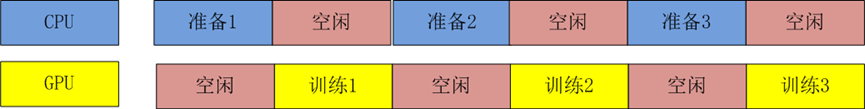
<center>图3-2 未使用prefetch的数据处理流程</center>

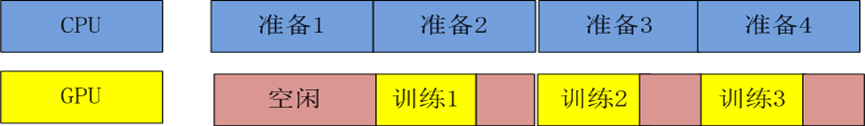
<center> 图3-3 使用prefetch后的数据处理流程</center>

### 3.1.4 构建模型
	使用tf.Module 封装变量及其计算，可以使用任何Python对象，有利于保存模型和跨平台部署使用。因此，可以基于TensorFlow开发任意机器学习模型(而非仅仅是神经网络模型)，并实现跨平台部署使用。  
1）构建模型。构建一个继承自tf.Module的模型,修改基类的构造函数，把需要初始化的变量放在__init__构造函数中，把参数变量的正向传播过程放在__call__方法中。__call__方法在模型实例化时，将自动调用。为提供更快的运行效率，通常用@tf.function进行装饰。

In [10]:
random_normal = tf.initializers.RandomNormal()
#继承tf.Module来构建模型变量
class NetModel(tf.Module): 
    def __init__(self,name = None):
        super(NetModel, self).__init__(name=name)
        self.w1 = tf.Variable(random_normal([32*32*3, 256]))
        self.b1 = tf.Variable(tf.zeros([256]))
        self.w2 = tf.Variable(random_normal([256, 128]))
        self.b2 = tf.Variable(tf.zeros([128]))
        self.w3 = tf.Variable(random_normal([128, 64]))
        self.b3 = tf.Variable(tf.zeros([64]))
        self.wout=tf.Variable(random_normal([64, 10]))
        self.bout=tf.Variable(tf.zeros([10]))

     
    # 实现参数的正向传播，为加速训练，这里把动态图转换为AutoGraph
    @tf.function
    def __call__(self,x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        x = tf.nn.relu(x@self.w3 + self.b3)
        y = tf.nn.softmax(x@self.wout + self.bout)
        return y    
    
model = NetModel()

/Users/lhc456/miniconda/envs/tf_test/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


2）定义损失函数和评估函数。

In [11]:
def cross_entropy(y_pred, y_true):
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(y_true=y_true, y_pred=y_pred)
    
    return tf.reduce_mean(loss_)


def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.reshape(tf.cast(y_true, tf.int64), [-1]))

    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.optimizers.Adam(learning_rate)


### 3.1.5 训练模型
1）实现反向传播。这里使用自动微分机制，并使用优化器实现梯度的自动更新，具体过程如下：  
（1）打开一个 GradientTape() 作用域  
（2）在此作用域内，调用模型（正向传播）并计算损失  
（3）在作用域之外，检索模型权重相对于损失的梯度  
（4）根据梯度使用优化器来更新模型的权重  
（5）利用优化器进行反向传播（更新梯度）

In [12]:
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = model(x)
        loss = cross_entropy(pred, y)
        
    #自动微分，并自动实现参数的反向传播
    gradients = g.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

2）定义训练过程。

In [13]:
train_loss_list = []
train_acc_list = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    batch_x = tf.reshape(batch_x, [-1, 32 * 32 * 3])
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = model(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        train_loss_list.append(loss)
        train_acc_list.append(acc)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

2023-11-26 23:58:50.102961: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-26 23:58:50.103121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x10xi1>'
2023-11-26 23:58:51.335065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-26 23:59:00.787674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is e

step: 1000, loss: 1.767623, accuracy: 0.375000
step: 2000, loss: 1.444571, accuracy: 0.515625
step: 3000, loss: 1.521384, accuracy: 0.562500
step: 4000, loss: 1.449242, accuracy: 0.437500
step: 5000, loss: 1.276509, accuracy: 0.500000
step: 6000, loss: 1.340293, accuracy: 0.453125
step: 7000, loss: 1.328102, accuracy: 0.656250
step: 8000, loss: 1.222456, accuracy: 0.515625
step: 9000, loss: 1.259498, accuracy: 0.546875
step: 10000, loss: 1.164537, accuracy: 0.609375
step: 11000, loss: 0.919542, accuracy: 0.625000
step: 12000, loss: 1.193579, accuracy: 0.625000
step: 13000, loss: 1.180165, accuracy: 0.546875
step: 14000, loss: 1.157321, accuracy: 0.609375
step: 15000, loss: 1.148469, accuracy: 0.625000
step: 16000, loss: 0.963408, accuracy: 0.625000
step: 17000, loss: 1.182585, accuracy: 0.625000
step: 18000, loss: 1.015938, accuracy: 0.640625
step: 19000, loss: 1.088773, accuracy: 0.609375
step: 20000, loss: 0.984584, accuracy: 0.593750
step: 21000, loss: 1.216623, accuracy: 0.500000
s

3）可视化运行过程。

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/Users/lhc456/miniconda/envs/tf_test/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

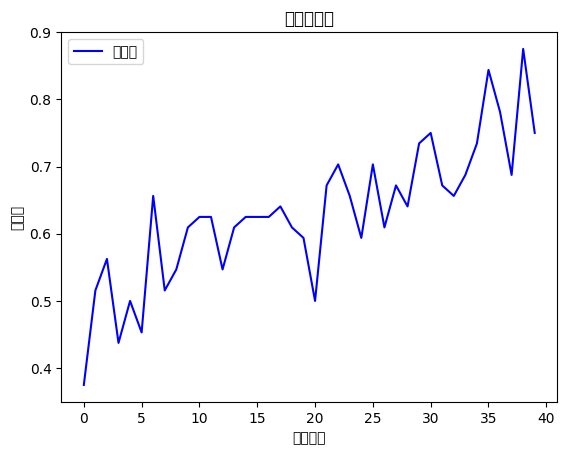

In [14]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.title('训练准确率')
plt.xlabel('迭代次数')
plt.ylabel('准确率')
plt.plot(train_acc_list, color=(0, 0, 1), label='准确率')
plt.legend(loc='best')
plt.show()

图3-4 随着迭代次数增加，模型准确率的变化

### 3.1.6 测试模型
	对模型进行测试。

In [15]:
test_total_batch = int(len(x_test) / batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch = x_test[i*batch_size:(i+1)*batch_size]
    test_image_batch = tf.reshape(test_image_batch, [-1, 32 * 32 * 3])
    test_label_batch = y_test[i*batch_size:(i+1)*batch_size]
    pred = model(test_image_batch)
    test_batch_acc = accuracy(pred,test_label_batch)
    test_acc_sum += test_batch_acc
test_acc = float(test_acc_sum / test_total_batch)
print("Test accuracy:{:.6f}".format(test_acc))

Test accuracy:0.526442


构建模型只使用了全连接层，没有对网络进行优化，测试能达到这个效果也不错。后续我们将采用数据增强、卷积神经网络等方法进行优化。

### 3.1.7 保存恢复模型
1）保存模型。

In [15]:
tf.saved_model.save(model, 'model_path')

INFO:tensorflow:Assets written to: model_path\assets


2）恢复模型。

In [16]:
#加载模型,包括权重参数，但没有model中定义的函数
mymodel = tf.saved_model.load("model_path")

3）利用恢复的模型进行测试。

In [17]:
test_total_batch = int(len(x_test) / batch_size)
test_acc_sum = 0.0
for i in range(test_total_batch):
    test_image_batch = x_test[i*batch_size:(i+1)*batch_size]
    test_image_batch = tf.reshape(test_image_batch, [-1, 32 * 32 * 3])
    test_label_batch = y_test[i*batch_size:(i+1)*batch_size]
    pred = mymodel(test_image_batch)
    test_batch_acc = accuracy(pred,test_label_batch)
    test_acc_sum += test_batch_acc
test_acc = float(test_acc_sum / test_total_batch)
print("Test accuracy:{:.6f}".format(test_acc))

Test accuracy:0.530148


由结果可知，它与原模型的测试结果完全一样！